In [1]:
%matplotlib inline

import sys
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from imageio import imread, imwrite
from skimage.transform import resize
sys.path.append('..')

import meters as ms
from meters.batch import MeterBatch
from meters.dataset import B,V,F,R,P, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet18, MobileNet,DenseNet121, ResNet50, VGG19, MobileNet_v2, InceptionResNet_v2

from IPython.display import clear_output
from time import sleep

plt.style.use('seaborn-poster')
plt.style.use('ggplot')


def add_bb(img, bb, c, width=3):
    lc, lr, w, h = bb.astype(np.int)
    im_height = img.shape[0] - 1
    im_width = img.shape[1] - 1
    for i in range(width):
        img[min(im_height,lr):min(im_height,lr)+i, min(im_width,lc):min(im_width,lc+w),:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc):min(im_width,lc)+i,:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc+w):min(im_width,lc+w)+i,:]=c
        img[min(im_height,lr+h):min(im_height,lr+h)+i, min(im_width,lc):min(im_width,lc+w),:]=c
    return img

def show_examples(ppl, n=20, real=True, test=False, sleep_=0.1, width=2):
    for _ in range(n):
        clear_output(True)
        batch = ppl.next_batch(1, shuffle=True, n_epochs=None)
        image = batch.images[0].copy()
        
        if real:
            bbox = batch.coordinates[0] * np.tile(image.shape[1::-1], 2)
            image = add_bb(image, bbox, [0,1,0], width)
        plt.figure(figsize=(9,9))
        
        if test:
            bbox = np.maximum(0, ppl.get_variable('predictions')[0] * np.tile(image.shape[1::-1], 2))
            image = add_bb(image, bbox, [1,0,0], width)
            if real:
                plt.title('{:.2f}'.format(ppl.get_variable('current_iou')), fontsize=18)
#             print('{:.2f}'.format(ppl.get_variable('current_iou')[0]))
        plt.imshow(image)
        
        plt.grid(False)
        plt.show()
        sleep(sleep_)
    

shape_to_feed = (120, 120)

images_folder = "../data/images"
labels_folder = "../data/labels"

clean_images_folder = "../data/images_clean"

/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Preprocess images

In [2]:
# def remove_background(image, bbox):
#     """ Removes white stripes from the edges of an image."""
#     rows_mean, columns_mean = image.mean((1, 2)), image.mean((0, 2))
#     rows_nonwhite = np.argwhere(rows_mean < 250)
#     columns_nonwhite = np.argwhere(columns_mean < 250)

#     new_bbox = bbox.copy()

#     dr, dc = 0, 0
#     if rows_mean[0] > 250:
#         dr = rows_nonwhite[0][0]
        
#     if columns_mean[0] > 250:
#         dc = columns_nonwhite[0][0]
        
#     new_bbox[1] -= dr
#     new_bbox[0] -= dc

#     left_top = (rows_nonwhite[0][0], columns_nonwhite[0][0])
#     right_bottom = (rows_nonwhite[-1][0], columns_nonwhite[-1][0])

#     return image[left_top[0]:right_bottom[0], left_top[1]:right_bottom[1]].copy(), new_bbox


# labels = pd.read_csv(os.path.join(labels_folder, 'new_labels.csv'), index_col='file_name')
# images = [imread(os.path.join(images_folder, imname)) for imname in sorted(os.listdir(images_folder))]
# corrected_bboxes = {}
# for i in tqdm(range(len(labels))):
#     image = images[i]
#     bbox = labels.iloc[i]['coordinates']
#     name = labels[i:i+1].index[0]
    
#     image, bbox = remove_background(image, [float(x) for x in bbox.split(', ')])
#     bbox = np.round(bbox * np.tile(shape_to_feed, 2) / np.tile(image.shape[1::-1],2))
#     image = resize(image, shape_to_feed)
    
#     corrected_bboxes[name] = bbox
#     imwrite(os.path.join(clean_images_folder, name + '.png'), image)
# corrected_bboxes = pd.DataFrame.from_dict(corrected_bboxes, orient='index').sort_index()
# corrected_bboxes.index.name = 'file_name'
# corrected_bboxes.to_csv(os.path.join(labels_folder, 'corrected_bboxes.csv'))

# Generate augmented images

In [3]:
# real_images = np.stack([imread(os.path.join(clean_images_folder, x))
#                         for x in sorted(os.listdir(clean_images_folder))])

# corrected_bboxes = pd.read_csv(os.path.join(labels_folder, 'corrected_bboxes.csv'),
#                                index_col='file_name').values

# dset = Dataset(index=np.arange(len(real_images)), batch_class=MeterBatch)
# dset.cv_split(0.85, shuffle=True)


# test_load_ppl = \
#     Pipeline()\
#     .load(src=real_images, components='images')\
#     .load(src=corrected_bboxes, components='coordinates')\
#     .multiply(multiplier=1/255., preserve_type=False)\
#     .normalize_bb(src=['images', 'coordinates'],\
#                   dst=['images', 'coordinates'])
    
# train_load_ppl = \
#     Pipeline()\
#     .load(src=real_images, components='images')\
#     .load(src=corrected_bboxes, components='coordinates')\
    
    
# def factor_sampler(size, p_square = 0.5):
#     if np.random.binomial(1, p_square):
#         return np.random.uniform(0.3, 1.7, (size,))
#     return np.random.uniform(0.3, 1.7, (size,2))

# def shift_sampler(size):
#     return np.hstack((np.random.uniform(-60, 60, (size, 1)),\
#                       np.random.uniform(-15, 10, (size, 1)),\
#                       np.zeros((size, 1))))

# def shape_sampler(size, crop_size=1):
#     return np.random.randint(20, 50, (size, crop_size, 2))

# def color_sampler(size, crop_size=1):
#     return np.random.uniform(0, 1, (size, crop_size, 3))

# def background_sampler(size, shape=(120, 120, 3), p_solid = 0.5):
#     if np.random.binomial(1, p_solid):
#         return np.ones((size, 120,120, 3))*color_sampler(size)[:, np.newaxis,...]
#     return np.random.uniform(0, 1, (size,) + shape)

# def random_origin_sampler(size, max_=3):
#     return [['random'] * np.random.randint(0, max_) for _ in range(size)]
# channels = np.array((0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)), dtype=object)
# def channels_sampler(size):
#     return channels[np.random.randint(len(channels), size=size)]

# mode_generator=lambda size: np.random.choice(['constant', 'nearest', 'wrap'], size)
 
# augmentation_ppl = (\
#     Pipeline()\
#     .flip(mode=P(R(lambda size: np.random.choice(['ud', 'lr'], size, p=[1/3,2/3]))),\
#            src=['images', 'coordinates'],\
#            dst=['images', 'coordinates'],\
#            p=2/3.)
#     .scale(factor=P(R(factor_sampler)),\
#            src=['images', 'coordinates'],\
#            dst=['images', 'coordinates'],\
#            preserve_shape=True,
#            mode=P(R(mode_generator)), p=1)\
#     .rotate(angle=P(R('uniform',-20, 20)),\
#             src=['images', 'coordinates'],\
#             dst=['images', 'coordinates'],\
#             p=1,
#            mode=P(R(mode_generator)))\
#     .shift(shift=P(R(shift_sampler)),\
#            src=['images', 'coordinates'],\
#            dst=['images', 'coordinates'],\
#            mode=P(R(mode_generator)), p=1)\
#     .multiply(multiplier=1/255., preserve_type=False)\
#     .multiply(multiplier=P(R('uniform', 0.3, 1.7)), p=1)\
#     .put_on_background(origin='random', background=P(R(background_sampler)), mask=0.03)
# #     .multiply(multiplier=P(R('uniform', 0.3, 1.7)), p=1)\
#     .fill_crop(origins=P(R(random_origin_sampler)),\
#                shapes=P(R(shape_sampler, crop_size=2)),\
#                colors=P(R(color_sampler, crop_size=2)), p=0.8)\
#     .salt(size=lambda: np.random.randint(1, 10, 2),\
#           color=lambda: np.random.uniform(0, 1, 3),\
#           p_noise=P(R('uniform', 0.005, 0.01)),\
#           p=0.1)\
#     .posterize(colors_number=R('randint',8,254), p=0.5)\
#     .invert(channels=P(R(channels_sampler)), p=0.3)
#     .multiplicative_noise(noise=lambda size: np.random.uniform(0.9, 1.1,size=size), p=0.9)\
#     .additive_noise(noise=lambda size: np.random.normal(0, 0.01,size=size), p=0.9)\
#     .gaussian_filter(sigma=P(R('uniform', 0.001, 1)), p=1)
#     .normalize_bb(src=['images', 'coordinates'],\
#                   dst=['images', 'coordinates']))


# # train
# bboxes = dict()
# bbox_pipeline = (train_load_ppl
#                  + Pipeline().init_variable(name='bboxes', init_on_each_run=dict)
#                  + augmentation_ppl
#                  + Pipeline().imsave(components='images')) << dset.train

# for batch in tqdm(bbox_pipeline.gen_batch(batch_size=len(dset.train) // 10,
#                                           n_epochs=180, shuffle=True, drop_last=False)):
#     pass
# bboxes = bbox_pipeline.get_variable('bboxes')
# (pd.DataFrame
#      .from_dict(bboxes, orient='index')
#      .sort_index()
#      .to_csv('../labels/aug_bboxes.csv'))

# bbox_pipeline = test_load_ppl << dset.test
# bboxes = dict()
# for batch in tqdm(bbox_pipeline.gen_batch(batch_size=len(dset.test) // 10,
#                                           n_epochs=1, shuffle=False, drop_last=False)):
#     names = ['aug' + str(x) for x in np.random.randint(10**14, 10**15, len(batch))]
#     for i in range(len(batch)):
#         bboxes[names[i]] = batch.coordinates[i]
#         imwrite('../data/test_aug/'+names[i]+'.png', batch.images[i])
# (pd.DataFrame
#      .from_dict(bboxes, orient='index')
#      .sort_index()
#      .to_csv('../labels/aug_bboxes_test.csv'))

In [4]:
show_examples((train_load_ppl + augmentation_ppl) << dset.train, n=100, sleep_=0.5)

NameError: name 'train_load_ppl' is not defined

# train\test datasets

In [ ]:
os.scandir?


In [ ]:
def read_data(path_images, path_bboxes, shape_to_feed=(120,120)):
    images_dir = sorted(os.listdir(path_images))
    images = np.zeros((len(images_dir),) + shape_to_feed + (3,), dtype=np.uint8)
    for i, imfile in tqdm(enumerate(images_dir)):
        if imfile.endswith('png'):
            images[i] = imread(os.path.join(path_images, imfile))
    bboxes = pd.read_csv(path_bboxes, index_col=0).values
    dset = Dataset(index=np.arange(len(images)), batch_class=MeterBatch)
    return images, bboxes, dset

In [ ]:
images_dir = sorted(os.listdir('../data/augmented_images/'))[1:]
train_images = np.zeros((len(images_dir),) + shape_to_feed + (3,), dtype=np.uint8)
for i, imfile in tqdm(enumerate(images_dir)):
    if imfile.endswith('png'):
        train_images[i] = imread('../data/augmented_images/'+imfile)
train_bboxes = pd.read_csv('../labels/aug_bboxes.csv', index_col=0).values
train_dset = Dataset(index=np.arange(len(train_images)), batch_class=MeterBatch) 

In [ ]:
test_images_dir = sorted(os.listdir('../data/test_aug/'))
test_images = np.zeros((len(test_images_dir),) + shape_to_feed + (3,), dtype=np.uint8)
for i, imfile in tqdm(enumerate(test_images_dir)):
    if imfile.endswith('png'):
        test_images[i] = imread('../data/test_aug/'+imfile)
test_bboxes = pd.read_csv('../labels/aug_bboxes_test.csv', index_col=0).values
test_dset = Dataset(index=np.arange(len(test_images)), batch_class=MeterBatch)

In [5]:
train_load_ppl = \
    Pipeline()\
    .load(src=train_images, components='images')\
    .load(src=train_bboxes, components='coordinates')\
    .multiply(multiplier=1/255., preserve_type=False)
    
test_load_ppl = \
    Pipeline()\
    .load(src=test_images, components='images')\
    .load(src=test_bboxes, components='coordinates')\
    .multiply(multiplier=1/255., preserve_type=False)

NameError: name 'train_images' is not defined

# Datasets' images

## train

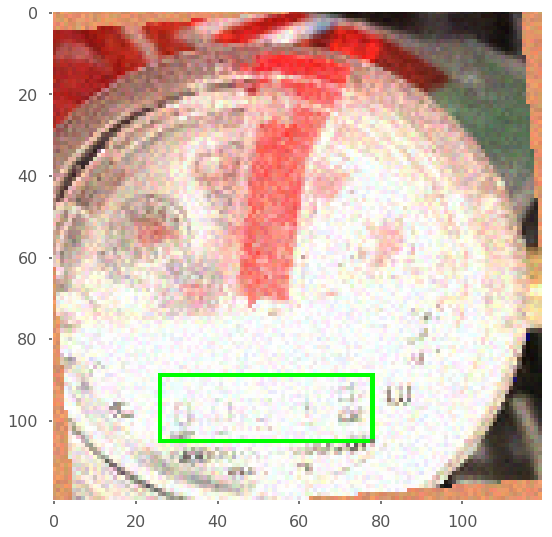

In [7]:
show_examples(train_load_ppl<<train_dset, 30, sleep_=0.1, width=2)

## test

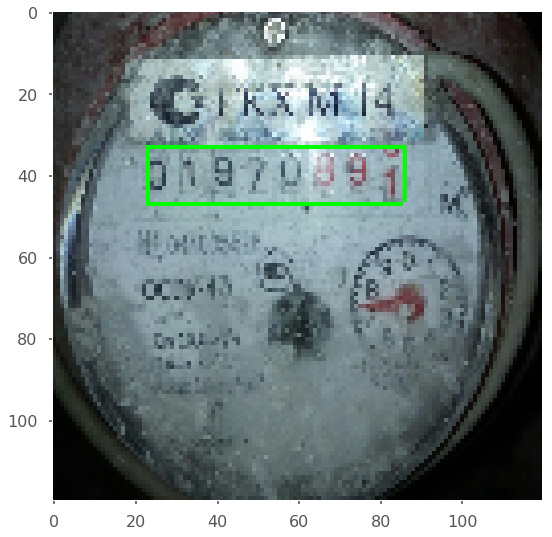

In [8]:
show_examples(test_load_ppl<<test_dset, 200, sleep_=0.1, width=2)

# Bounding box regression

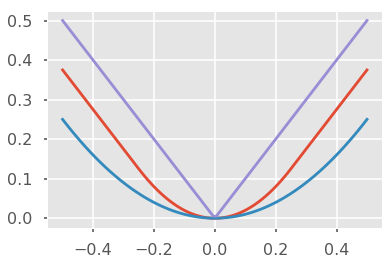

In [9]:
def smooth_l1_np(delta, mu=0.5):
    abs_delta = np.abs(delta)
    quadratic = np.minimum(mu, abs_delta)
    return quadratic**2/(2*mu) + abs_delta - quadratic

x = np.linspace(-0.5,.5,100)
plt.plot(x, smooth_l1_np(x, mu=0.25))
plt.plot(x, x**2)
plt.plot(x, np.abs(x))

In [10]:
import tensorflow as tf
def smooth_l1(labels, predictions, mu=0.02, scope=None, *args, **kwargs):
    error = predictions - labels
    abs_error = tf.abs(error)
    quadratic = tf.minimum(mu, abs_error)
    losses = quadratic ** 2 / (2 * mu) + abs_error - quadratic
    return tf.reduce_mean(losses)

In [137]:

batch_size = 80
epoch_size=len(train_dset) // batch_size

# learning rate decat values
values = list(100*np.array([0.01, 0.001, 0.0001, 0.00005, 0.00001]))
boundaries = list((epoch_size * np.array([10, 20, 40, 400])).astype(np.int32))

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
train_ppl = (Pipeline()
         .init_variable('model_arch', ResNet18)
         .init_variable('current_loss', init_on_each_run=0)
         .init_variable('current_iou', init_on_each_run=0)
         .init_variable('predictions', init_on_each_run=0)
         .init_model('dynamic', V('model_arch'), 'model',
                     config={"session" : {'config' : session_config},
                             'common' : {'regularizer' : tf.contrib.layers.l2_regularizer(0.001)},
                             'body': {'width_factor' : 1., },
                             'inputs' : {'images': {'shape': B('image_shape'),
                                                    'data_format': 'channels_last'},
                                         'labels': {'name': 'targets', 'shape' : (4,)}},
#                              'loss' : {'name' : 'huber', 'delta' : 0.2},
                             'decay' : {'name':"exp", "decay_rate" : 0.5, 'learning_rate' : 0.01,\
                                        "decay_steps" : int(3*epoch_size), 'staircase' : True},
                             'loss' : smooth_l1,
#                              'decay' : {'name' : 'const',
#                                         'boundaries' : boundaries,
#                                         'values' : values},
#                              'optimizer' : {'name' : 'GradientDescent',
                             'optimizer': {'name' : 'Momentum', 'momentum' : 0.95, 'use_nesterov' : True},
#                                            'learning_rate': 0.1},
                             'input_block/inputs' : 'images'})
           + train_load_ppl\
           + Pipeline()\
         .train_model('model', fetches=['loss', 'predictions'],
                      feed_dict={'images': B('images'),
                                 'labels': B('coordinates')},
                      save_to=[V('current_loss'), V('predictions')], use_lock=False)
         .iou()
        )
train_pipeline = train_ppl << train_dset




env: CUDA_VISIBLE_DEVICES=0


In [139]:
test_ppl =(Pipeline()\
         .import_model('model', train_pipeline)\
         .init_variable('current_iou', init_on_each_run=0)
         .init_variable('current_loss', init_on_each_run=0)
         .init_variable('predictions', init_on_each_run=0)\
         + test_load_ppl + Pipeline()\
         .predict_model('model', fetches=['loss', 'predictions'],\
                      feed_dict={'images': B('images'),\
                                 'labels': B('coordinates')},\
                      save_to=[V('current_loss'), V('predictions')])
         .iou())
test_pipeline = test_ppl << test_dset

In [140]:
def show_examples_val(ppl, a, width=2):
    for ai in a:
        batch = ppl.next_batch(1, shuffle=True, n_epochs=None)
        image = batch.images[0].copy()
        bbox = batch.coordinates[0] * np.tile(image.shape[1::-1], 2)
        plt.figure(figsize=(9,9))
        image = add_bb(image, bbox, [0,1,0], width)
        bbox = ppl.get_variable('predictions')[0] * np.tile(image.shape[1::-1], 2)
        image = add_bb(image, bbox, [1,0,0], width)
        ai.imshow(image);
        ai.set_title('iou: {:.2f}'.format(ppl.get_variable('current_iou')), fontsize=18)
        
        ai.grid(False);
        
def plot_metrics(loss, test_loss, iou, test_iou, show_img=False, ppl=None):
    if show_img==False:
        f, a = plt.subplots(1, 2, figsize=(16,9));
    else:
        f, a = plt.subplots(1, 2, figsize=(16, 5));
    x = np.arange(1, len(loss)+1)
    a = a.flatten()
    a[0].semilogy(x, loss, color='b', label='train')
    a[0].semilogy(x, test_loss, color='orange', label='test')
    a[0].legend()
    a[0].set_title('loss', fontsize=18)
    a[1].plot(x, iou, label='train', color='b')
    a[1].plot(x, test_iou, label='test', color='orange')
    a[1].legend()
    a[1].set_title('iou', fontsize=18)
    if show_img:
        f, a = plt.subplots(10, 3, figsize=(16, 64));
        show_examples_val(ppl, a.flatten());
    plt.show();
    print('-'*50)
    
def validate(ppl):
    iou, loss = 0, 0
    for i, tb in enumerate(ppl.gen_batch(batch_size=batch_size, n_epochs=1, drop_last=False), 1):
        iou += ppl.get_variable('current_iou')
        loss += ppl.get_variable('current_loss')
    return iou / i, loss / i

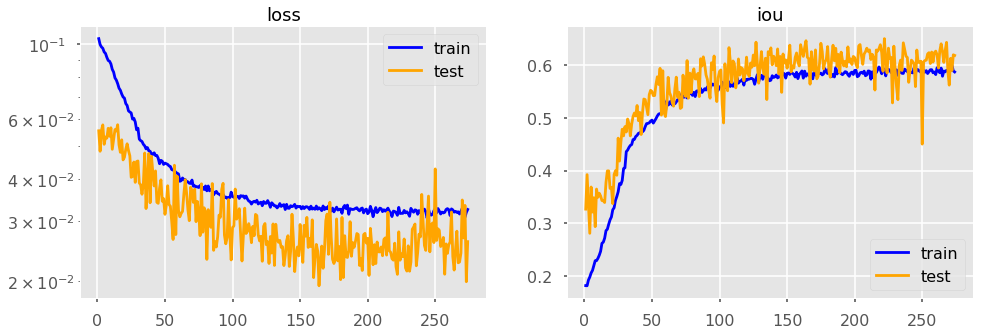

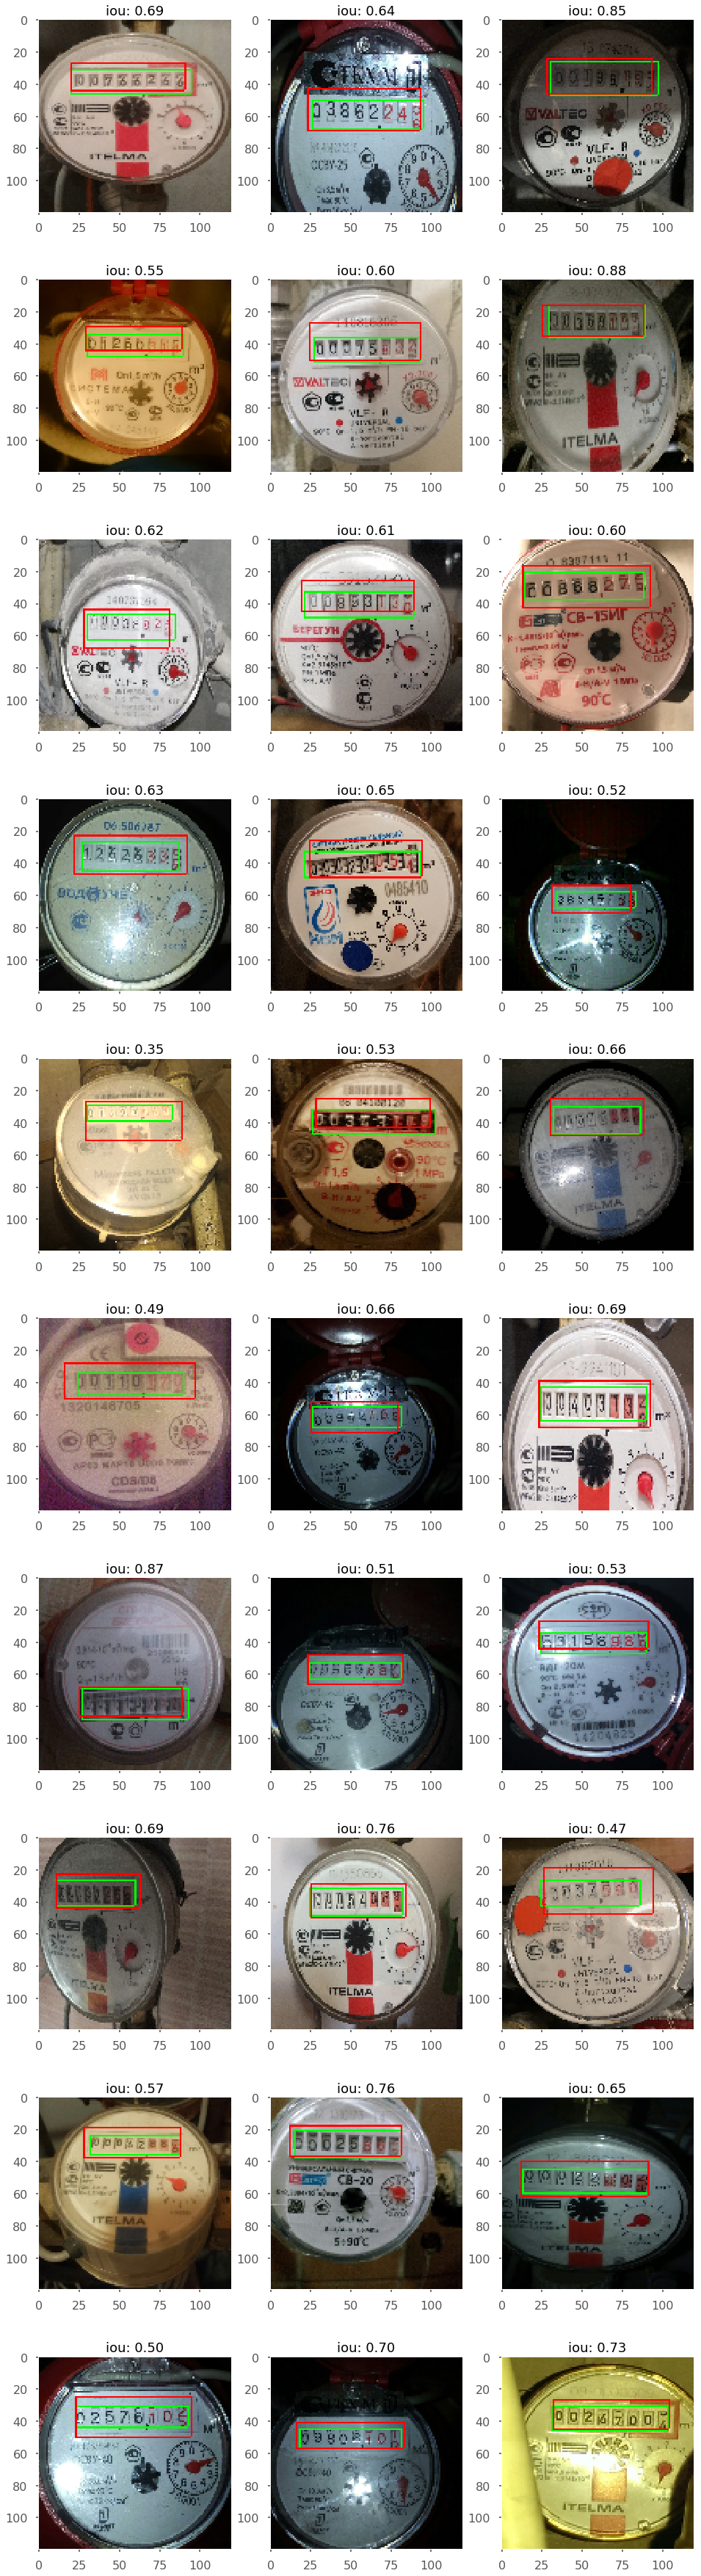

--------------------------------------------------


In [ ]:
alpha = 1 / 50

iou_value = 0
loss_value = 0

losses = []
test_losses = []
iou_values = []
iou_test_values = []

best_iou = 0


log_file = 'train_log.txt'
with open(log_file, 'w') as f:
    f.write('each epoch lasts for {} iterations\n'.format(epoch_size))


for i, b in tqdm(enumerate(train_pipeline.gen_batch(batch_size=batch_size,
                                                    shuffle=True,
                                                    n_epochs=33,
                                                    drop_last=False,
                                                    prefetch=2), 1)):
    loss_value = (1 - alpha) * loss_value + alpha * train_pipeline.get_variable('current_loss')
    iou_value = (1 - alpha) * iou_value + alpha * train_pipeline.get_variable('current_iou')
    
    if i % 10 == 0 and i < (epoch_size // 10):
         print(i, 'train loss: {:.1e}'.format(loss_value), 'train iou: {:.2f}'.format(iou_value))
            
    if i % (epoch_size // 10) == 0:
        losses.append(loss_value)
        iou_values.append(iou_value)

        iou, loss = validate(test_pipeline)
        iou_test_values.append(iou)
        test_losses.append(loss)
        
        clear_output(True)
        log = 'epoch {0:d}.{1:d}: train loss: {2:.3e}, test loss: {3:.3e}, train iou: {4:.3f}, test iou: {5:.3f}\n'\
            .format(i // epoch_size, int((i % epoch_size) * 10 / epoch_size),\
                    loss_value, test_losses[-1],\
                    iou_value, iou_test_values[-1])
            
        with open(log_file, 'a') as f:
            f.write(log)
            
        if iou_test_values[-1] > best_iou:
            best_iou = iou_test_values[-1]
            for file in os.listdir('models'):
                file_path = os.path.join('models', file)
                if os.path.isfile(file_path):
                    os.remove(file_path)
            model = train_pipeline.get_model_by_name('model')
            model.save('models/')
            with open(log_file, 'a') as f:
                f.write('\nNew best model is acquired at epoch {0:d} with test iou {1:.3f} and test loss {2:.3e}\n\n'.format(i // epoch_size, iou, loss))
            
            
        plot_metrics(losses, test_losses, iou_values, iou_test_values, show_img=True, ppl=test_pipeline);

In [ ]:
# save the last one
model = train_pipeline.get_model_by_name('model')
model.save('../resnet_for_poor_33_epochs_iou//')

In [81]:
show_examples(test_pipeline, n=100, sleep_=0.2, test=True, width=2)

KeyboardInterrupt: 

# Load model from a file

#  БАГ С ЗАГРУЗКАМИ МОДЕЛЕЙ

In [60]:
ppl = Pipeline().init_model('dynamic', TFModel, 'model',
                     config={'load' : {'path' : '../model_71iou_mse/'},
                             'build': False}) << uber_dset
# ppl = 

In [61]:
b = (ppl<<uber_dset).next_batch(1)

In [62]:
ppl.get_model_by_name('model')

INFO:tensorflow:Restoring parameters from ../model_71iou_mse/model-70658


In [6]:
from meters.dataset.dataset.models.tf import TFModel
from meters.dataset.batch_image import ImagesBatch
import tensorflow as tf


session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
class DummyBatch(MeterBatch):
    components = 'images', 'resized_images'

uber_dset = Dataset(index=FilesIndex(path='../data/meters_in_the_wild/*', no_ext=True), batch_class=DummyBatch)
pipeline = Pipeline().load(src='../data/meters_in_the_wild/', fmt='image',components='images') << uber_dset
    
session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True    
uber_test_load_ppl = \
    Pipeline()\
    .load(src='../data/meters_in_the_wild/', fmt='image',components='images')\
    .resize((120, 120), src='images', dst='resized_images')\
    .multiply(multiplier=1/255., src='resized_images', dst='resized_images', preserve_type=False)

uber_test_ppl =(Pipeline()\
#            .import_model('model', train_pipeline)\
         .init_model('dynamic', TFModel, 'model',
                     config={'load' : {'path' : 'models/resnet_for_poor_last_epoch_iou69/'},
                             'build': False})
         .init_variable('predictions', init_on_each_run=0)\
         + uber_test_load_ppl + Pipeline()\
         .predict_model('model', fetches=['predictions'],\
                        feed_dict={'images': B('resized_images')},\
                        save_to=[ V('predictions')]))
uber_test_pipeline = uber_test_ppl << uber_dset

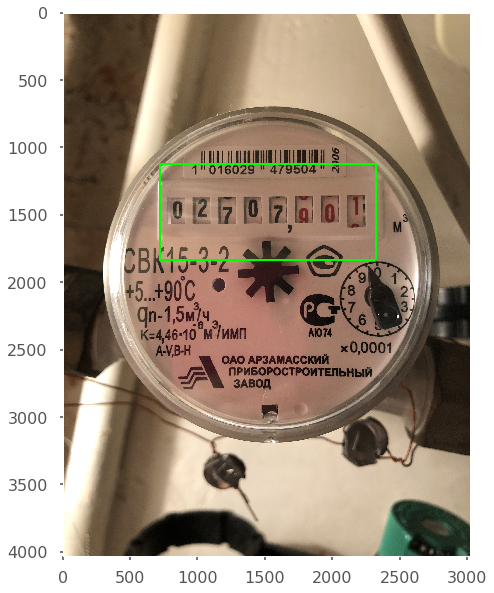

In [8]:
b = uber_test_pipeline.next_batch(1, shuffle=False, drop_last=False, n_epochs=None)
im = b.images[0]
bbox = uber_test_pipeline.get_variable('predictions')[0] * np.tile(im.shape[1::-1], 2)
plt.figure(figsize=(10,10))
plt.imshow(add_bb(im, bbox, width=15, c=[0,255,0]))
plt.grid(False)

In [9]:
from skimage.transform import re

/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


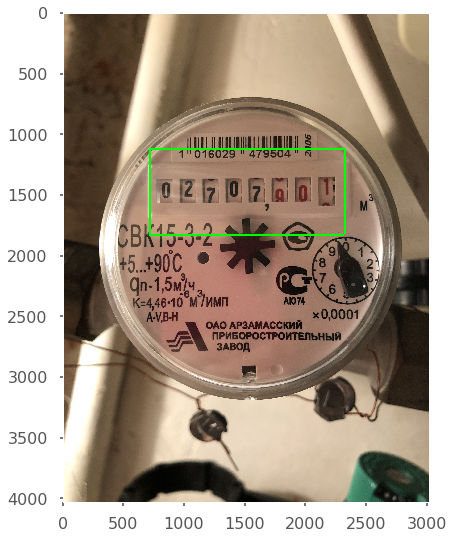

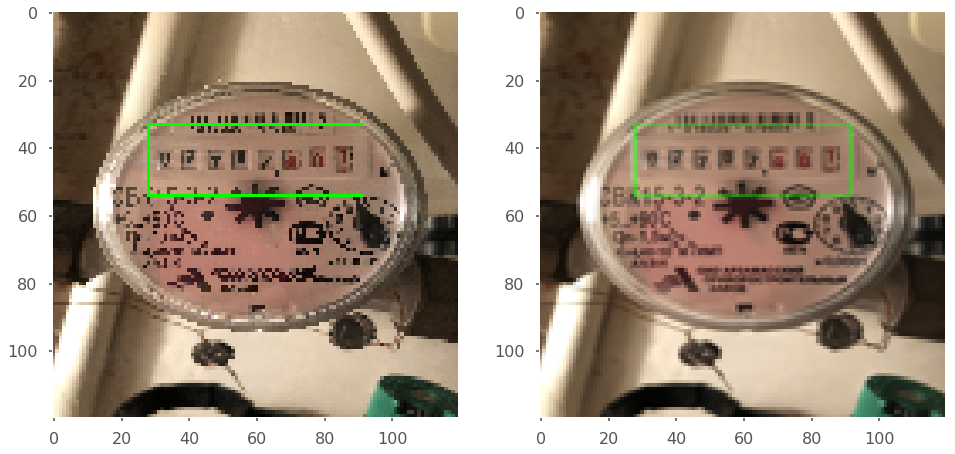

In [25]:
from skimage.transform import resize as skimresize
from scipy.misc import imresize as spimresize
im=  b.images[0]
f, a = plt.subplots(1, 1, figsize=(16,9))
a.imshow(im)
a.grid(False)
f, a = plt.subplots(1, 2, figsize=(16,9))
a[0].imshow(skimresize(im, (120,120)))
a[0].grid(False)

a[1].imshow(spimresize(im, interp='bicubic', size=(120,120)))
a[1].grid(False)